## Create Chunked Dataset

In [1]:
import os
import getpass

from datasets import load_dataset, DatasetDict
from huggingface_hub import login
from transformers import AutoTokenizer
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


In [ ]:
# DATASET_REPO = 'roneneldan/TinyStories'
# STORY_KEY = 'text'
DATASET_REPO = 'SimpleStories/SimpleStories'
STORY_KEY = 'story'

CHUNK_LENGTH = 512

TRAIN_SPLIT_PERCENTAGE = 4

In [3]:

train_dataset = load_dataset(DATASET_REPO, split='train', columns=['token_ids'])
val_dataset = load_dataset(DATASET_REPO, split='test')



README.md:   0%|          | 0.00/549 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/58.1M [00:00<?, ?B/s]

Cancellation requested; stopping current tasks.


KeyboardInterrupt: 

In [6]:
# Construct 
"""
Custom Character Tokenizer for Hugging Face Hub
Creates a tokenizer where each of your 84 characters is a separate token
"""

from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers
from transformers import PreTrainedTokenizerFast
# add ../doclang_scaling to sys.path
import sys
import os
sys.path.append(os.path.relpath( '..'))
from doclang_scaling.tokenizer import fast_tokenizer


# Step 5: Test the tokenizer
test_text = "Hello World!"
encoded = fast_tokenizer.encode(test_text)
decoded = fast_tokenizer.decode(encoded)
print(f"Original: {test_text}")
print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")
print(f"\nVocabulary size: {len(fast_tokenizer)}")

TOKENIZER_REPO = "MikiV/SimpleStories-Char-Tokenizer"
fast_tokenizer.push_to_hub(TOKENIZER_REPO)


Original: Hello World!
Encoded: [39, 58, 82, 82, 33, 19, 10, 33, 16, 82, 15, 8]
Decoded: Hello World!

Vocabulary size: 88


No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/MikiV/SimpleStories-Char-Tokenizer/commit/85e27f2dde13f88fc11c8fce5745458073187f7e', commit_message='Upload tokenizer', commit_description='', oid='85e27f2dde13f88fc11c8fce5745458073187f7e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/MikiV/SimpleStories-Char-Tokenizer', endpoint='https://huggingface.co', repo_type='model', repo_id='MikiV/SimpleStories-Char-Tokenizer'), pr_revision=None, pr_num=None)

In [7]:
# tokenize the dataset  

tokenizer = fast_tokenizer
print(f"Our tokenizer vocab size: {tokenizer.vocab_size}")

def tokenize_function(examples):
    return tokenizer(examples[STORY_KEY], truncation=False, padding='do_not_pad')
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=train_dataset.column_names).select_columns(['input_ids'])
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=val_dataset.column_names).select_columns(['input_ids'])
tokenized_train_dataset, tokenized_val_dataset

Our tokenizer vocab size: 88


(Dataset({
     features: ['input_ids'],
     num_rows: 2115696
 }),
 Dataset({
     features: ['input_ids'],
     num_rows: 21371
 }))

In [7]:


def chunk_dataset_with_map(dataset, token_column='input_ids', chunk_length=CHUNK_LENGTH):
    """
    Memory-efficient version using dataset.map() and batched processing.
    """
    
    def chunk_batch(batch):
        chunked_batch = {col: [] for col in batch.keys()}
        
        for i in range(len(batch[token_column])):
            tokens = batch[token_column][i]
            token_count = len(tokens)
            num_chunks = token_count // chunk_length
            
            for chunk_idx in range(num_chunks):
                start_idx = chunk_idx * chunk_length
                end_idx = start_idx + chunk_length
                chunk_tokens = tokens[start_idx:end_idx]
                
                # Add chunk to batch
                for col in batch.keys():
                    if col == token_column:
                        chunked_batch[col].append(chunk_tokens)
                    else:
                        chunked_batch[col].append(batch[col][i])
        
        return chunked_batch
    
    # Use map wiph batched=True for memory efficiency
    chunked_dataset = dataset.map(
        chunk_batch,
        batched=True,
        remove_columns=dataset.column_names,  # Remove original columns
        batch_size=1000,  # Adjust based on your memory constraints
    )
    
    return chunked_dataset
chunked_dataset_train = chunk_dataset_with_map(tokenized_train_dataset, chunk_length=CHUNK_LENGTH)
chunked_dataset_val = chunk_dataset_with_map(tokenized_val_dataset, chunk_length=CHUNK_LENGTH)

Map:   0%|          | 0/2115696 [00:00<?, ? examples/s]

Map:   0%|          | 0/21371 [00:00<?, ? examples/s]

In [8]:
print("Train dataset length:", len(chunked_dataset_train))
print("Validation dataset length:", len(chunked_dataset_val))
DS_REPO_NAME = DATASET_REPO.replace('/', '-') + f'-chunked-{CHUNK_LENGTH}'

print(train_dataset)
print(val_dataset)

dict_dataset = DatasetDict({
    'train': chunked_dataset_train,
    'validation': chunked_dataset_val,
})

dict_dataset.push_to_hub(f"MikiV/{DS_REPO_NAME}", private=True)




Train dataset length: 4136391
Validation dataset length: 41774
Dataset({
    features: ['story', 'topic', 'theme', 'style', 'feature', 'grammar', 'persona', 'initial_word_type', 'initial_letter', 'word_count', 'character_count', 'num_paragraphs', 'avg_word_length', 'avg_sentence_length', 'flesch_reading_ease', 'flesch_kincaid_grade', 'dale_chall_readability_score', 'num_stories_in_completion', 'expected_num_stories_in_completion', 'generation_id', 'model'],
    num_rows: 2115696
})
Dataset({
    features: ['story', 'topic', 'theme', 'style', 'feature', 'grammar', 'persona', 'initial_word_type', 'initial_letter', 'word_count', 'character_count', 'num_paragraphs', 'avg_word_length', 'avg_sentence_length', 'flesch_reading_ease', 'flesch_kincaid_grade', 'dale_chall_readability_score', 'num_stories_in_completion', 'expected_num_stories_in_completion', 'generation_id', 'model'],
    num_rows: 21371
})


Uploading the dataset shards:   0%|          | 0/17 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/datasets/MikiV/SimpleStories-SimpleStories-chunked-512/commit/d0785f26b75becc79c2c7dee26d33aedadcb6226', commit_message='Upload dataset', commit_description='', oid='d0785f26b75becc79c2c7dee26d33aedadcb6226', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/MikiV/SimpleStories-SimpleStories-chunked-512', endpoint='https://huggingface.co', repo_type='dataset', repo_id='MikiV/SimpleStories-SimpleStories-chunked-512'), pr_revision=None, pr_num=None)

## Dataset Exploration

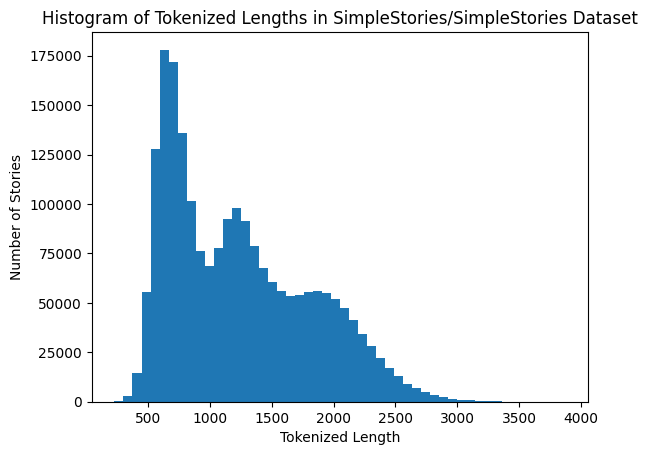

In [8]:
# Historgram of tokenized lengths
lengths = [len(x) for x in tokenized_train_dataset['input_ids']]
plt.hist(lengths, bins=50)
plt.xlabel('Tokenized Length')
plt.ylabel('Number of Stories')
plt.title(f'Histogram of Tokenized Lengths in {DATASET_REPO} Dataset')
plt.show()

In [13]:
total_tokens_train = len(chunked_dataset_train)*CHUNK_LENGTH/1e6
total_tokens_val = len(chunked_dataset_val)*CHUNK_LENGTH/1e6
total_tokens_original = sum(lengths)/1e6
print(f"Total available tokens = {total_tokens_original}M tokens")
print(f"Total tokens in chunked dataset (train) = {total_tokens_train}M tokens")
print(f"Total tokens in chunked dataset (test) = {total_tokens_val}M tokens")
print(f"We are left with {(total_tokens_train + total_tokens_val)/total_tokens_original * 100}% of the original tokens (train)")

NameError: name 'chunked_dataset_train' is not defined

In [14]:
for thresh in [256, 512, 600, 1024]:
    x = sum(l >= thresh for l in lengths) / len(lengths) * 100
    print(f"{x}% of stories are at least {thresh} tokens")

99.9983456980587% of stories are at least 256 tokens
97.12742284335746% of stories are at least 512 tokens
90.07943485264424% of stories are at least 600 tokens
56.29499701280335% of stories are at least 1024 tokens


In [ ]:
tokenizer.get_vocab()

{'dimmed': 3876,
 'real': 925,
 'try': 964,
 '##ent': 163,
 'giggled': 1810,
 'can': 270,
 'figure': 1113,
 'maps': 3007,
 'zoomed': 2801,
 'wanted': 388,
 '##ged': 1869,
 '##ived': 2863,
 'adventures': 1015,
 'don': 1490,
 'rest': 2054,
 'cars': 3969,
 'hopes': 2067,
 'decide': 3666,
 'bran': 2282,
 'outs': 3539,
 'dimm': 3463,
 'fea': 1317,
 'ins': 3039,
 '##bles': 2571,
 'growing': 1962,
 'cla': 1581,
 'door': 675,
 'kingdom': 1320,
 'wished': 1144,
 'x': 55,
 'sprink': 3711,
 'hungry': 2694,
 'tripped': 3511,
 '##roud': 789,
 '##found': 2487,
 '##reat': 311,
 'pat': 685,
 'chair': 2927,
 'brea': 620,
 'retur': 613,
 'answered': 2794,
 'steps': 2595,
 'snowball': 2847,
 '##p': 75,
 'exchanged': 3217,
 'sibling': 2501,
 'scents': 4015,
 'dreamer': 3770,
 'join': 738,
 '##oney': 2759,
 'shin': 516,
 'larger': 3794,
 '##ences': 3560,
 'firef': 2892,
 'beautiful': 684,
 'watched': 668,
 'cry': 1119,
 'window': 1359,
 '##pped': 377,
 'rainbow': 1574,
 'should': 1099,
 'disc': 3990,
 'awa

In [ ]:
# Ove chunked dataset, find the most common tokens and what percentage of the dataset they cover
from collections import Counter
all_tokens = [token for chunk in chunked_dataset['input_ids'] for token in chunk]
token_counts = Counter(all_tokens)
total_tokens = len(all_tokens)
most_common = token_counts.most_common(20)
for token, count in most_common:
    print(f"Token: {token} ({tokenizer.decode([token])}), Count: {count}, Percentage: {count/total_tokens*100:.2f}%")

NameError: name 'chunked_dataset' is not defined